In [1]:
# Basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Trying out a bunch of things. 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder

#Maths 
from numpy import absolute
from numpy import mean
from numpy import std

#Visalization
from matplotlib import pyplot as plt
import seaborn as sns

# Clean up options
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 2)

In [2]:
# Read All IPL Data
deliveres = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/IPL Ball-by-Ball 2008-2020.csv")
matches = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/IPL Matches 2008-2020.csv")
# Populated with data from cricinfo for bowlers who have bowled in atleasst 10 matches
# bowler_data = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/Bowlers.csv")

del_df = deliveres.copy()
# del_df = del_df[del_df.id >= 980901]
match_df = matches.copy()
# match_df = match_df[match_df.id >= 980901]

In [3]:
# batsman_df = del_df[del_df.batsman == selected_batsman]
batsman_df = del_df
comb = pd.merge(batsman_df, match_df, on = 'id', how='left')

In [4]:
comb = comb.drop(["non_striker", "extra_runs", "total_runs" , 'batting_team', 'non_boundary' , 'dismissal_kind' , 'fielder' , 'extras_type' , 'city' , 'date' , 'player_of_match' , 'neutral_venue' , 'team1' , 'team2' , 'toss_winner' , 'toss_decision' , 'winner' , 'result' , 'result_margin' , 'eliminator' , 'method' , 'umpire1' , 'umpire2'], axis=1)

In [5]:
tmpRuns = pd.DataFrame(comb.groupby(['id', 'batsman']).batsman_runs.sum()).rename(columns = {'batsman_runs' : 'totalRuns'}).reset_index()
tmpBalls = pd.DataFrame(comb.groupby(['id', 'batsman']).batsman_runs.count()).rename(columns = {'batsman_runs' : 'totalBalls'}).reset_index()

In [6]:
comb = comb.loc[:, ~comb.columns.str.contains('^Unnamed')]

In [7]:
comb = pd.merge(comb, tmpRuns, how = 'left' , left_on = ['id','batsman'], right_on = ['id','batsman'])
comb = pd.merge(comb, tmpBalls, how = 'left' , left_on = ['id','batsman'], right_on = ['id','batsman']).reset_index(drop=True)

OversLeftAtEntry = pd.DataFrame(20 - comb.groupby(['id' , 'batsman']).over.min()).rename(columns = {'over' : 'oversLeft'}).reset_index()

comb = comb.drop(['over' , 'ball' , 'batsman_runs', 'player_dismissed', 'bowler' , 'is_wicket'] , axis=1)
comb = comb.drop_duplicates().reset_index(drop=True)

In [8]:
comb = pd.merge(comb, OversLeftAtEntry, how = 'left' , left_on = ['id','batsman'], right_on = ['id','batsman'])

In [9]:
comb['index_col'] = comb.index

AvgRuns = pd.DataFrame(comb.groupby(['batsman'])['totalRuns'].rolling(2, min_periods =1).mean()).reset_index().rename(columns = {'level_1' : 'index'})

AvgRuns.columns = ['batsman' , 'index_col' , 'RollingAvg']

comb = comb.merge(AvgRuns[['index_col' , 'RollingAvg']] , on='index_col')

comb = comb.drop(['index_col'], axis=1)

In [10]:
comb['matchesAgainstOpposition'] = comb.groupby(['batsman' , 'bowling_team']).id.cumcount() + 1
comb['matchesAtVenue'] = comb.groupby(['batsman' , 'venue']).id.cumcount() + 1

comb['runsAgainstOppostion'] = comb.groupby(['batsman' , 'bowling_team']).totalRuns.cumsum()
comb['runsAtVenue'] = comb.groupby(['batsman' , 'venue']).totalRuns.cumsum()

comb['AvgAgainstOpposition'] = comb.apply(lambda x: x['runsAgainstOppostion'] / x['matchesAgainstOpposition'] , axis=1)
comb['AvgAtVenue'] = comb.apply(lambda x: x['runsAtVenue'] / x['matchesAtVenue'] , axis=1)

comb['RunBucket'] = comb.apply(lambda x: (x['totalRuns'] // 25) + 1, axis=1)
comb['RunBucket'] = comb['RunBucket'].apply(lambda x: 5 if x>=5 else x)

In [11]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
comb['batsman_cat'] = labelencoder.fit_transform(comb['batsman'])

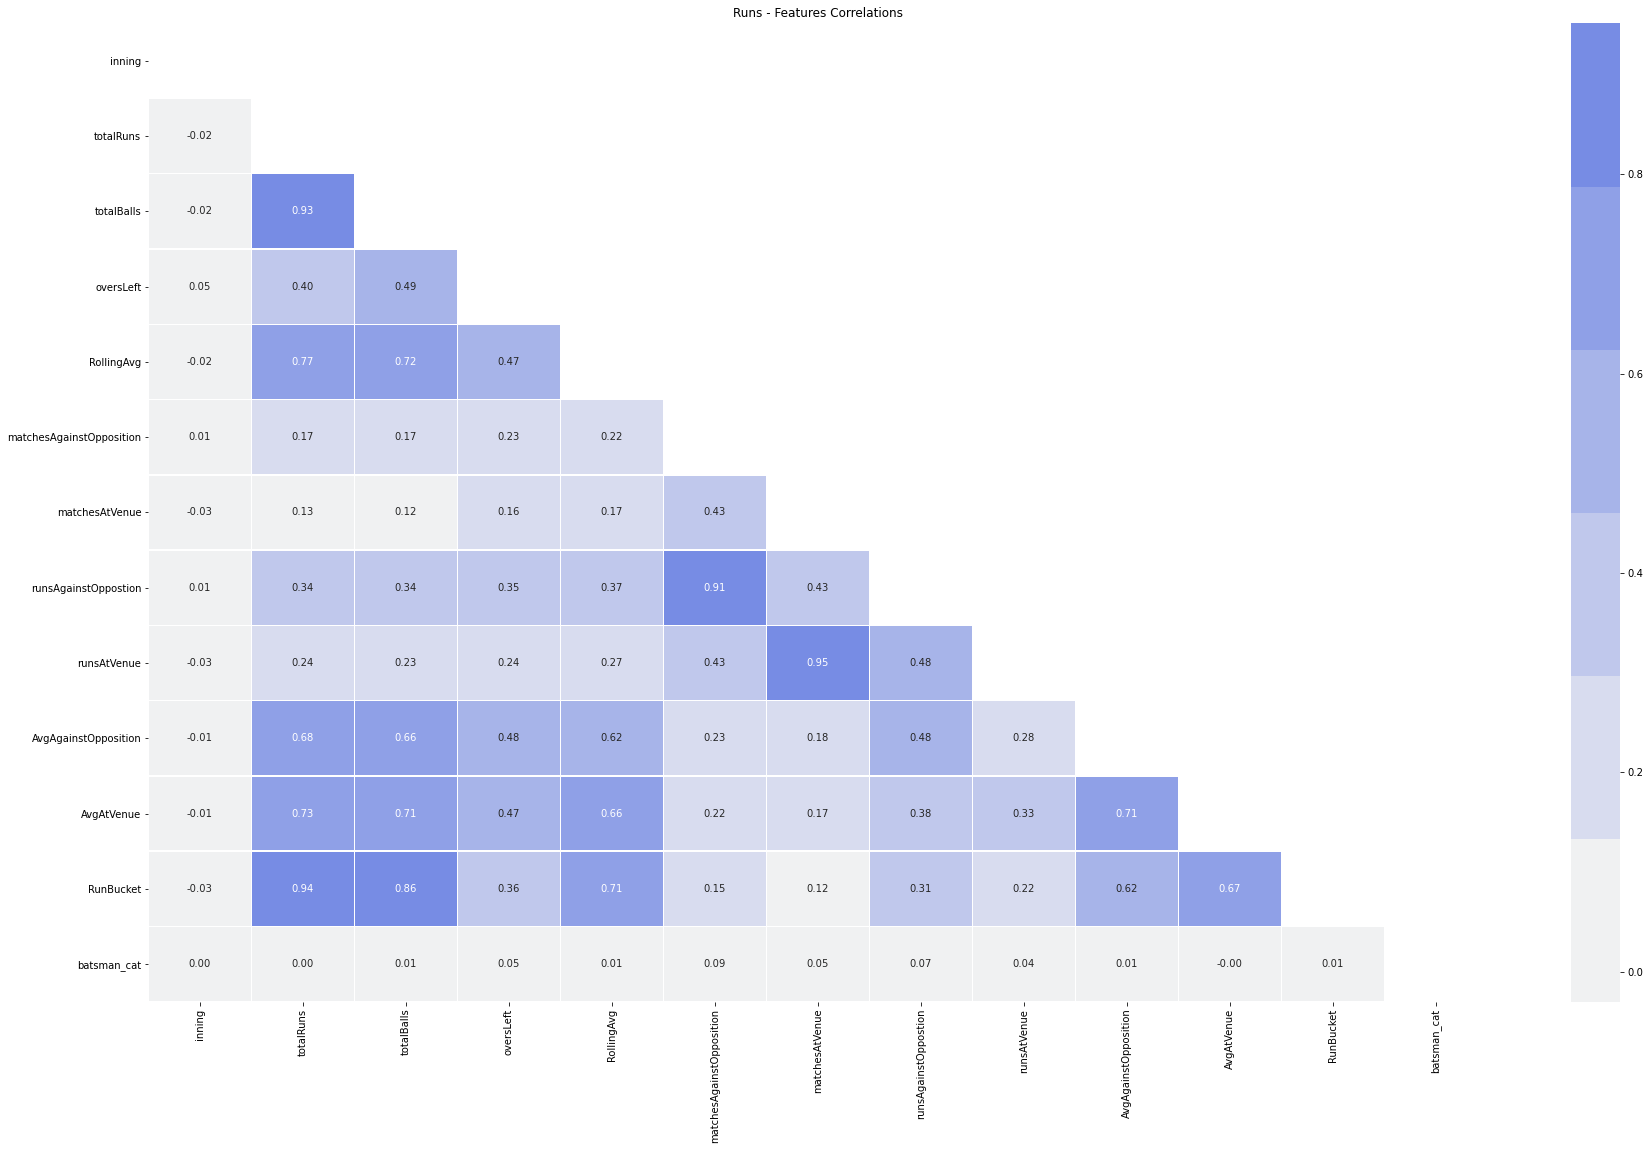

In [12]:
# Plot a correlation Heat Map 

fig, ax = plt.subplots(figsize=(30, 18))
corr = comb.drop(labels = ['id'] , axis=1).corr()


myMask = np.zeros_like(corr)
myMask[np.triu_indices_from(myMask)] = True

colormap = sns.light_palette((260, 75, 60), input="husl")

sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=myMask)
plt.title('Runs - Features Correlations')

plt.show()

### Predicting Batsman's score based on above metrics

In [13]:
# Choosing Features 
x = comb.drop(labels = ['id' , 'inning' , 'totalRuns', 'batsman' , 'totalBalls' , 'bowling_team' , 'venue', 'matchesAgainstOpposition' , 'matchesAtVenue' , 'runsAgainstOppostion' , 'runsAtVenue', 'RunBucket'], axis=1)

# We need prediction for Total Runs, always. So this is fixed 
y = comb['totalRuns'].values

# Split the data into test/train - 70/30 
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = 0.3 , random_state = 42)

In [14]:
# Linear Regressor 
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)

print(linear_regressor.score(x_train, y_train))
y_pred = linear_regressor.predict(x_test)
print(linear_regressor.score(x_test, y_test))
mean_absolute_error(y_test, y_pred)

0.7029425755888625
0.685146235225556


8.33557773538733

In [15]:
# Poisson Regressor 
# debug this - not looking correct 
poisson_regressor = PoissonRegressor()
poisson_regressor.fit(x_train, y_train)

print(poisson_regressor.score(x_train, y_train))
y_pred = poisson_regressor.predict(x_test)
print(poisson_regressor.score(x_test, y_test))
mean_absolute_error(y_test, y_pred)

0.571840791380527
0.5771198766352423


9.789795654020008

In [16]:
# Random Forest Regressor
rdf_regressor = RandomForestRegressor(n_estimators=100,max_features=None)
rdf_regressor.fit(x_train,y_train)

print(rdf_regressor.score(x_train,y_train))
y_pred = rdf_regressor.predict(x_test)
print(rdf_regressor.score(x_test,y_test))
mean_absolute_error(y_test, y_pred)

0.9652274429252371
0.7282287197610953


6.627599342285558

In [17]:
# GaussianNB
nb_model=GaussianNB()
nb_model.fit(x_train,y_train)

print(nb_model.score(x_train,y_train))
y_pred=nb_model.predict(x_test)
print(nb_model.score(x_test,y_test))
mean_absolute_error(y_test, y_pred)

0.09972982497356983
0.09345026034530009


11.183337900794738

In [18]:
# Decision Tree
dt_regressor = DecisionTreeRegressor(criterion='mse', splitter='best',
                             max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                             max_features=None, random_state=None,
                             max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             ccp_alpha=0.0)


dt_regressor.fit(x_train,y_train)

print(dt_regressor.score(x_train,y_train))
y_pred=dt_regressor.predict(x_test)
print(dt_regressor.score(x_test,y_test))
mean_absolute_error(y_test, y_pred)

1.0
0.4655872222952341


8.995615237051247

In [19]:
x_test.head(3)

,oversLeft,RollingAvg,AvgAgainstOpposition,AvgAtVenue,batsman_cat
8496,13,15.0,10.4,13.00,460
4046,19,25.0,29.0,31.89,379
8296,10,5.5,28.0,11.50,115


In [20]:
def predict_score(df, oversLeft, RollingAvg, AvgAgainstOpposition, AvgAtVenue, batsman): 
    
    print("OversLeft = " + str(oversLeft))
    print("RollingAvg = " + str(RollingAvg))
    print("AvgAgainstOpposition = " + str(AvgAgainstOpposition))
    print("AvgAtVenue = " + str(AvgAtVenue))
    print("batsman = " + str(batsman))
    print()
    
    test_input = [[ oversLeft, RollingAvg, AvgAgainstOpposition, AvgAtVenue, batsman]]
    
    # print(test_input)
    print ("Linear Regression Prediction - " + str(linear_regressor.predict(test_input)))
    print ("Poisson Regression Prediction - " + str(poisson_regressor.predict(test_input)))
    print ("Random Forest Regression Prediction - " + str(rdf_regressor.predict(test_input)))
    print ("Gaussian Prediction - " + str(nb_model.predict(test_input)))
    print ("Decision Tree Regression Prediction - " + str(dt_regressor.predict(test_input)))
    
    real = df[(df.batsman_cat == batsman) & (df.oversLeft == oversLeft) & (df.AvgAgainstOpposition == AvgAgainstOpposition)].totalRuns.sum()
    print("Real output - " , str(real))

In [21]:
# Get a Prediction from all models for same data for comparison
predict_score(comb, 16, 41.5, 35.48, 30.62 , 505)

OversLeft = 16
RollingAvg = 41.5
AvgAgainstOpposition = 35.48
AvgAtVenue = 30.62
batsman = 505

Linear Regression Prediction - [41.55144891]
Poisson Regression Prediction - [33.44126199]
Random Forest Regression Prediction - [51.54]
Gaussian Prediction - [52]
Decision Tree Regression Prediction - [50.]
Real output -  50


### Predicting batsman's score range using Classification Algorithms

In [22]:
# Choosing Features 
x = comb.drop(labels = ['id' , 'inning' , 'batsman' , 'totalRuns', 'bowling_team' , 'venue', 'RunBucket', 'totalBalls' , 'matchesAgainstOpposition' , 'matchesAtVenue' , 'runsAgainstOppostion' , 'runsAtVenue'], axis=1)

# We need prediction for Run Buckets, always. So this is fixed 
y = comb['RunBucket'].values


# Split the data into test/train - 70/30 
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = 0.3 , random_state = 0)

In [23]:
x_test.head(5)

,oversLeft,RollingAvg,AvgAgainstOpposition,AvgAtVenue,batsman_cat
5762,6,18.5,8.4,10.72,179
8179,6,30.5,30.5,13.00,209
4296,20,48.5,42.5,84.00,42
541,14,44.0,31.0,28.00,125
9403,4,0.5,0.0,0.00,346


In [24]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(x_train, y_train)
y_pred = logistic_classifier.predict(x_test)

accuracy=accuracy_score(y_test,y_pred) 
precision=precision_score(y_test,y_pred,average='weighted')
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred,average='weighted')

print('Accuracy - {}'.format(accuracy))
print('Precision - {}'.format(precision))
print('Recall - {}'.format(recall))
print('F1 - {}'.format(f1))

Accuracy - 0.7034804055905728
Precision - 0.6726427906416966
Recall - 0.7034804055905728
F1 - 0.6838708399732009


In [25]:
RF_classifier = RandomForestClassifier(n_estimators=50)
RF_classifier.fit(x_train,y_train)
y_pred = RF_classifier.predict(x_test)

accuracy=accuracy_score(y_test,y_pred) 
precision=precision_score(y_test,y_pred,average='weighted')
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred,average='weighted')

print('Accuracy - {}'.format(accuracy))
print('Precision - {}'.format(precision))
print('Recall - {}'.format(recall))
print('F1 - {}'.format(f1))

Accuracy - 0.8046040010961908
Precision - 0.8054710403961216
Recall - 0.8046040010961908
F1 - 0.8043608477286369


In [26]:
nb_model=GaussianNB()
nb_model.fit(x_train,y_train)
y_pred=nb_model.predict(x_test)

accuracy=accuracy_score(y_test,y_pred) 
precision=precision_score(y_test,y_pred,average='weighted')
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred,average='weighted')

print('Accuracy - {}'.format(accuracy))
print('Precision - {}'.format(precision))
print('Recall - {}'.format(recall))
print('F1 - {}'.format(f1))

Accuracy - 0.7695258975061661
Precision - 0.7890526778041528
Recall - 0.7695258975061661
F1 - 0.7771789819734835


### Findings 

* We have taken into account only oversLeft, AverageAtVenue, AverageAgainstOpposition, RollingAverage from last 3 games. 
* For Regression Algorithms, Random Forest Regressor seems to work the best with MEA of ~6.5 
* For Classification, Random Forest Classification has a 80% accuracy of predicting 